In [1]:
import dbpy, stpy
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

## Check the detector ids

In [2]:
bl = 3
#run_number = 1548737
# run_number= 1476273

run_number = 1620711



taglist_byrun = list(dbpy.read_taglist_byrun(bl, run_number))
det_ids = dbpy.read_detidlist(bl, run_number)
print(det_ids)

('MPCCD-1N0-M06-001', 'MPCCD-1N0-M07-006')


### The 14th tag out of 18 corresponds to the laser shot when you execute a run using the “launcher for ns.”
### Please note that 0th tag is the first tag.

In [3]:
def read_mpccd_by_newest_run(bl=3, nth_tag=14, nth_det=0):
    newest_run_number = dbpy.read_runnumber_newest(bl)
    taglist_byrun = list(dbpy.read_taglist_byrun(bl, newest_run_number))
    det_id = dbpy.read_detidlist(bl, newest_run_number)[nth_det]
    strReader = stpy.StorageReader(det_id, bl, (newest_run_number, ))
    strBuffer = stpy.StorageBuffer(strReader)
    strReader.collect(strBuffer, taglist_byrun[nth_tag])
    data = strBuffer.read_det_data(0)
    return data

In [4]:
def read_mpccd_by_run(run_number, bl=3, nth_tag=14, nth_det=0):
    taglist_byrun = list(dbpy.read_taglist_byrun(bl, run_number))
    det_id = dbpy.read_detidlist(bl, run_number)[nth_det]
    strReader = stpy.StorageReader(det_id, bl, (run_number, ))
    strBuffer = stpy.StorageBuffer(strReader)
    strReader.collect(strBuffer, taglist_byrun[nth_tag])
    data = strBuffer.read_det_data(0)
    return data

In [5]:
def read_mpccd_all_tag_by_run(run_number, bl=3, nth_det=0):
    taglist_byrun = list(dbpy.read_taglist_byrun(bl, run_number))
    det_id = dbpy.read_detidlist(bl, run_number)[nth_det]
    strReader = stpy.StorageReader(det_id, bl, (run_number, ))
    strBuffer = stpy.StorageBuffer(strReader)
    strReader.collect(strBuffer, taglist_byrun[0])
    data0 = strBuffer.read_det_data(0)
    data_all = np.zeros(data0.shape)[np.newaxis]
    for tag in taglist_byrun:
        strReader.collect(strBuffer, tag)
        temp = strBuffer.read_det_data(0) 
        data_all = np.concatenate((data_all, temp[np.newaxis]), axis=0)
    data_all = np.delete(data_all, 0, 0)
    return data_all

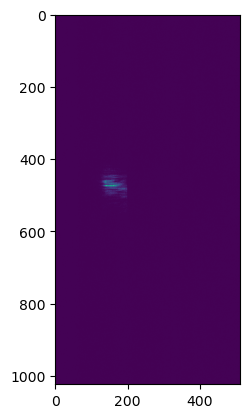

In [6]:
data = read_mpccd_by_run(run_number, nth_det=0)
plt.imshow(data)

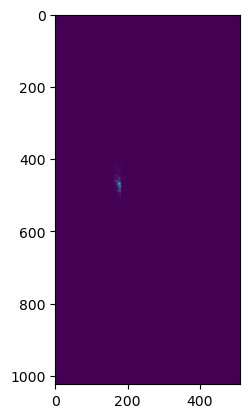

In [7]:
data = read_mpccd_by_run(run_number, nth_det=1)
plt.imshow(data)

In [8]:
# def read_mpccd_by_run(run_number, bl=3, nth_tag=14, nth_det=0):
#     taglist_byrun = list(dbpy.read_taglist_byrun(bl, run_number))
#     data_list = []
#     for nth_tag in range(len(taglist_byrun)):
#         # taglist_byrun = list(dbpy.read_taglist_byrun(bl, run_number))
#         det_id = dbpy.read_detidlist(bl, run_number)[nth_det]
#         strReader = stpy.StorageReader(det_id, bl, (run_number, ))
#         strBuffer = stpy.StorageBuffer(strReader)
#         strReader.collect(strBuffer, taglist_byrun[nth_tag])
#         data = strBuffer.read_det_data(0)
#         data_list.append(data)
#     data_array = np.array(data_list)
#     return data_array

def read_mpccd_by_run(run_number, bl=3, nth_det=0):
    """
    Efficiently reads and sums all MPCCD detector images for one run.
    Returns the summed 2D image (not per-tag stack).
    """
    # Get tags and detector info once
    taglist_byrun = list(dbpy.read_taglist_byrun(bl, run_number))
    det_id = dbpy.read_detidlist(bl, run_number)[nth_det]

    # Initialize the reader and buffer once
    strReader = stpy.StorageReader(det_id, bl, (run_number,))
    strBuffer = stpy.StorageBuffer(strReader)

    summed_image = None
    for tag in taglist_byrun:
        strReader.collect(strBuffer, tag)
        data = strBuffer.read_det_data(0)

        if summed_image is None:
            summed_image = np.zeros_like(data, dtype=float)

        summed_image += data

    return summed_image

In [17]:
def sum_multiple_runs(run_list, bl=3, nth_det=0, plot=True):
    """
    Sums all tags for each run, then sums all runs together.
    Optionally plots the final summed image.
    """
    total_sum = None

    for run in run_list:
        print(f"Reading and summing run {run}...")
        run_sum = read_mpccd_by_run(run, bl=bl, nth_det=nth_det)

        if total_sum is None:
            total_sum = np.zeros_like(run_sum, dtype=float)

        total_sum += run_sum

    return total_sum

In [18]:
run_list = [1620701, 1620702, 1620703, 1620704, 1620705, 1620706, 1620707, 1620708, 1620709, 1620710]

total_sum = sum_multiple_runs(run_list, bl=3, nth_det=0)

Reading and summing run 1620701...
Reading and summing run 1620702...
Reading and summing run 1620703...
Reading and summing run 1620704...
Reading and summing run 1620705...
Reading and summing run 1620706...
Reading and summing run 1620707...
Reading and summing run 1620708...
Reading and summing run 1620709...
Reading and summing run 1620710...


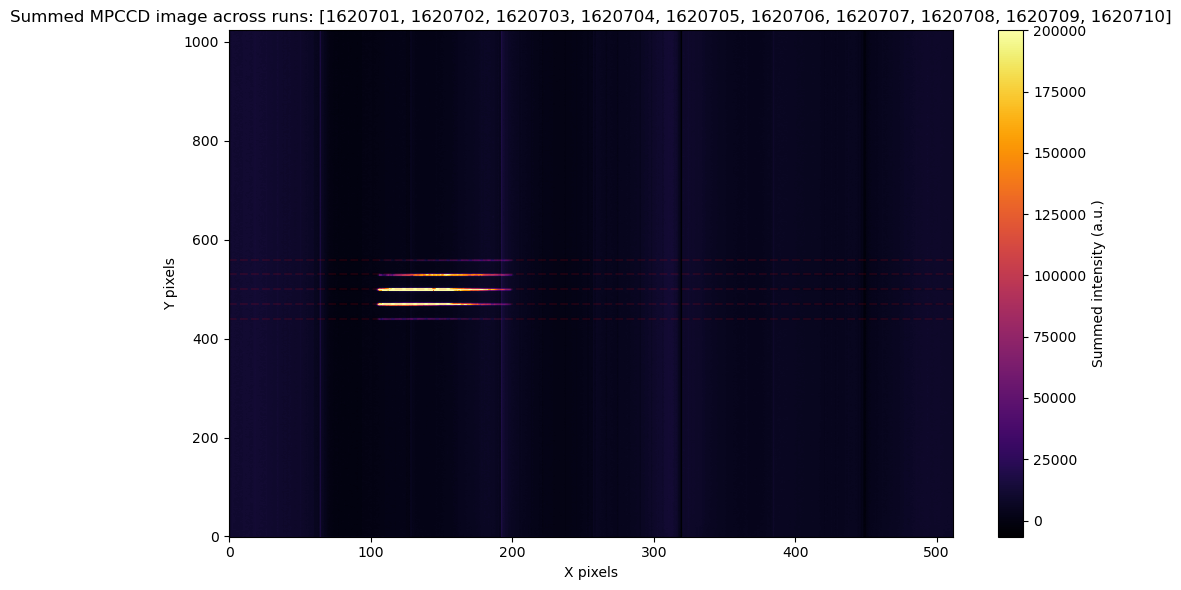

In [26]:
plt.figure(figsize=(10, 6))
plt.imshow(total_sum, cmap='inferno', origin='lower', aspect='auto', vmax=0.2e+6)
plt.colorbar(label="Summed intensity (a.u.)")
plt.title(f"Summed MPCCD image across runs: {run_list}")
plt.axhline(y=440, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=470, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=500, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=530, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=560, linestyle='--', color='red', alpha=0.1)
plt.xlabel("X pixels")
plt.ylabel("Y pixels")
plt.tight_layout()
plt.show()

In [27]:
run_list = [1620701, 1620702, 1620703, 1620704, 1620705, 1620706, 1620707, 1620708, 1620709, 1620710]

total_sum = sum_multiple_runs(run_list, bl=3, nth_det=1)

Reading and summing run 1620701...
Reading and summing run 1620702...
Reading and summing run 1620703...
Reading and summing run 1620704...
Reading and summing run 1620705...
Reading and summing run 1620706...
Reading and summing run 1620707...
Reading and summing run 1620708...
Reading and summing run 1620709...
Reading and summing run 1620710...


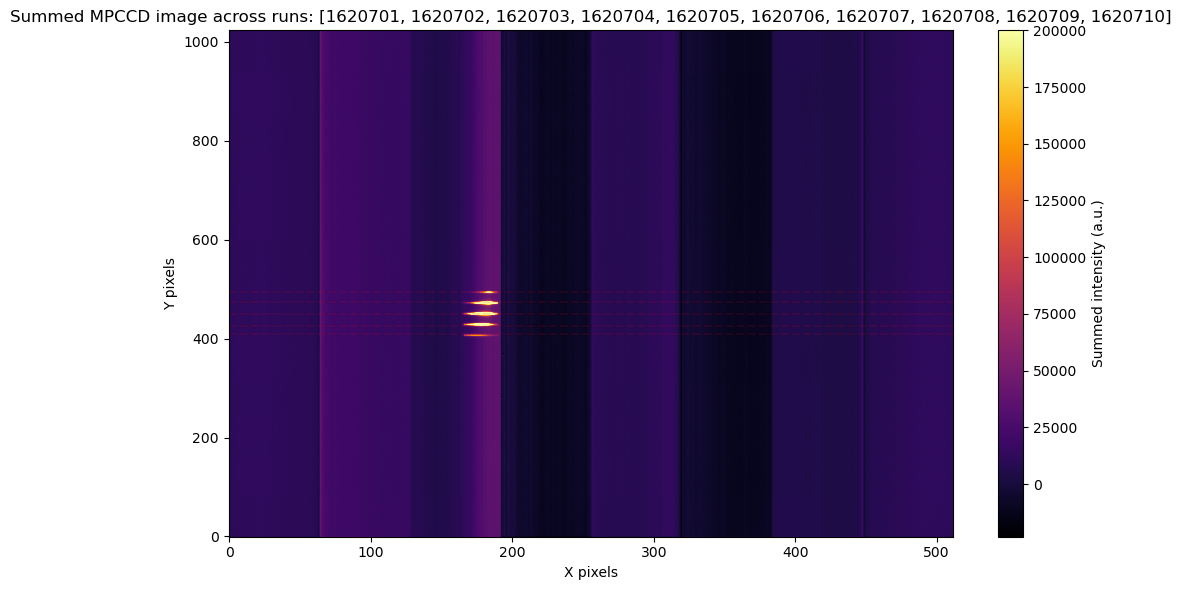

In [29]:
plt.figure(figsize=(10, 6))
plt.imshow(total_sum, cmap='inferno', origin='lower', aspect='auto', vmax=0.2e+6)
plt.colorbar(label="Summed intensity (a.u.)")
plt.title(f"Summed MPCCD image across runs: {run_list}")
plt.axhline(y=410, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=425, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=450, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=475, linestyle='--', color='red', alpha=0.1)
plt.axhline(y=495, linestyle='--', color='red', alpha=0.1)
plt.xlabel("X pixels")
plt.ylabel("Y pixels")
plt.tight_layout()
plt.show()